In [1]:
import numpy as np
import pandas as pd
import pickle
import cvxpy as cp

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
%matplotlib inline

In [2]:
# open and read file
with open('ruscorpora_upos_skipgram_300_5_2018.vec', encoding='utf-8') as f: #НКРЯ
    lines = f.readlines()

In [3]:
#check length of file 
len(lines)

195072

In [4]:
# get the list of words in the word embeddings
words = [lines[i].split()[0] for i in range(1, len(lines))]

In [5]:
# read file of chosen professions ("ГАРАНТ system")

df_prof = pd.read_csv('./professions.csv')

In [6]:
# full list of professions which we found in our corpus (professions for which we have word embeddings)
professions_list = []
for word in words:
    for prof in set(df_prof['профессии']):
        if word == prof + '_NOUN':
            professions_list.append(word)

In [7]:
# need to make a matrix out of the list of strings

lines_formatrix = lines[1:]
words_list = []
for i in range(len(lines_formatrix)):
    split_line = lines_formatrix[i].split(' ', 1)
    words_list.append(split_line[0])
    lines_formatrix[i] = split_line[1]
    
E = np.loadtxt(lines_formatrix)       #it is a matrix with all word embeddings from our model RNC 

In [8]:
# find the indexes of the profession (from the professions.csv) in the word embedding matrix
ind_prof = [i for i in range(len(words_list)) if words_list[i] in professions_list]

In [9]:
# create P matrix of vectors for the professions
P = E[ind_prof,:]

# check the shape of P 
P.shape

(459, 300)

In [10]:
# try to use male-female word pairs to get gender axis
# open and preprocess word pairs
with open('word_pairs.txt','r', encoding = 'utf-8') as of:
    word_pairs = of.readlines()
    
for i in range(len(word_pairs)):
    word_pairs[i] = word_pairs[i].strip()
word_pairs[0] = 'мужчина_NOUN'   
    
# find the indexes of these word pairs in the embedding matrix
ind_nouns = []
for i in range(len(words_list)):
    for elem in word_pairs:        
        if elem == words_list[i]:
            ind_nouns.append(i)
            
# separate indexes for male and female nouns
ind_male_noun = []
ind_female_noun = []
for i in range(len(ind_nouns)):
    if i % 2 == 0:
        ind_male_noun.append(ind_nouns[i])
    if i % 2 != 0:
        ind_female_noun.append(ind_nouns[i])
        
# make male and female matrix
male_matrix = E[ind_male_noun,:]
female_matrix = E[ind_female_noun,:]

# find the difference matrix (for the gender axis) and the use PCA to find the main principle component
from sklearn.decomposition import PCA

difference_matrix = male_matrix - female_matrix
pca = PCA(n_components = 10)
pca_forprojection = pca.fit(difference_matrix)
gender_axis_pca = pca_forprojection.components_[0]

# check the singular value decay
singular_values = pca_forprojection.singular_values_
print(singular_values)
# the singular value decay is not good, so we will use just man-woman vector for gender axis

[2.41463988 2.04141369 1.96470187 1.89613182 1.73493755 1.56332096
 1.53138261 1.49973152 1.412821   1.34707082]


In [11]:
# find vectors for мужчина и женщина
ind_man = words_list.index('мужчина_NOUN')
ind_woman = words_list.index('женщина_NOUN')

man = E[ind_man, :]
woman = E[ind_woman, :]
# b vector is gender axis
b = man - woman

In [12]:
# find projections of professions onto gender axis

def find_proj(P, b):
    projections = []
    gender_axis_norm = (b)/np.linalg.norm(b) # normalized gender axis

    for i in range(P.shape[0]):
        proj = np.dot(P[i,:], gender_axis_norm)
        projections.append(proj)
    return projections

Text(0.5, 0, '          <---- female                     ----> male')

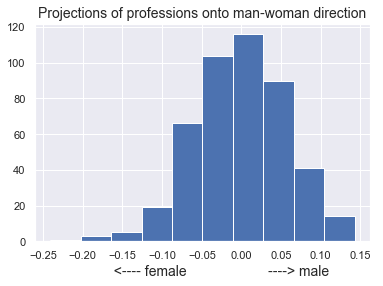

In [14]:
# plot distribution of projections

projections = find_proj(P, b)

plt.hist(projections)
plt.title('Projections of professions onto man-woman direction', size =14 )
plt.xlabel(' '*10 + '<---- female' + ' '*20 + ' ----> male', size = 14)


In [15]:
# find the bounds for extreme professions
right_bound = np.mean(projections) + 1.5*np.std(projections)
left_bound = np.mean(projections) - 1*np.std(projections)

In [16]:
# find and print the extreme professions for both male

ind_var_male = []
for i in range(len(projections)):
    if projections[i] > right_bound:
        ind_var_male.append(i)
        
#for i in ind_var_male:
 #   print(professions_list[i])

In [17]:
# find the extreme professions for both male and female

ind_var = []
for i in range(len(projections)):
    if projections[i] < left_bound or projections[i] >  right_bound:
        ind_var.append(i)
        
#for i in ind_var:
 #   print(professions_list[i])

In [18]:
# create file with selected extreme professions
with open('professions_for_selection','w',encoding = 'utf-8') as of:
    for i in ind_var:
        of.write(professions_list[i] + '\n')
    of.close()
    

In [19]:
with open('professions_after_selection','r', encoding = 'utf-8') as of:
    slist_rev = of.readlines()

In [20]:
# list of professions after selection (63 professions)
slist_rev = [slist_rev[i].strip() for i in range(len(slist_rev)-1)]

In [21]:
slist_rev

['художник_NOUN',
 'врач_NOUN',
 'командир_NOUN',
 'директор_NOUN',
 'учитель_NOUN',
 'президент_NOUN',
 'специалист_NOUN',
 'сотрудник_NOUN',
 'мастер_NOUN',
 'инженер_NOUN',
 'губернатор_NOUN',
 'кандидат_NOUN',
 'водитель_NOUN',
 'сторож_NOUN',
 'педагог_NOUN',
 'организатор_NOUN',
 'мэр_NOUN',
 'наблюдатель_NOUN',
 'повар_NOUN',
 'тренер_NOUN',
 'няня_NOUN',
 'смотритель_NOUN',
 'менеджер_NOUN',
 'официант_NOUN',
 'живописец_NOUN',
 'бухгалтер_NOUN',
 'фельдшер_NOUN',
 'скульптор_NOUN',
 'хранитель_NOUN',
 'дилер_NOUN',
 'почтальон_NOUN',
 'продюсер_NOUN',
 'ювелир_NOUN',
 'библиотекарь_NOUN',
 'декан_NOUN',
 'кинорежиссер_NOUN',
 'лаборант_NOUN',
 'программист_NOUN',
 'референт_NOUN',
 'бармен_NOUN',
 'реставратор_NOUN',
 'корректор_NOUN',
 'экспедитор_NOUN',
 'швея_NOUN',
 'брокер_NOUN',
 'проректор_NOUN',
 'балетмейстер_NOUN',
 'метеоролог_NOUN',
 'топограф_NOUN',
 'пчеловод_NOUN',
 'шеф-повар_NOUN',
 'юрисконсульт_NOUN',
 'гончар_NOUN',
 'крупье_NOUN',
 'ихтиолог_NOUN',
 'библи

In [22]:
# indices in words_list of 63 chosen professions
ind_prof_rev = [i for i in range(len(words_list)) if words_list[i] in slist_rev]                         

In [23]:
# make A by deleting the extreme professions and man and woman vectors
A = np.delete(E, ind_prof_rev+[ind_man]+[ind_woman], axis=0)

In [24]:
A.shape

(195006, 300)

In [25]:
# make P out of the extreme professions
P_rev= E[ind_prof_rev,:]

In [26]:
P_rev.shape

(63, 300)

In [24]:
# SVD 
u, s, vt = np.linalg.svd(A, full_matrices = False)

In [25]:
# save SVD matrices

with open('matrix_s', 'wb') as f:
        pickle.dump(s, f)
        
with open('matrix_vt', 'wb') as f:
        pickle.dump(vt, f)

In [27]:
#if you don't have memory for computing SVD you can load them
with open('matrix_s', 'rb') as f:
    s = pickle.load(f)

with open('matrix_vt', 'rb') as f:
    vt = pickle.load(f)

In [28]:
# reshape B for optimization
B_reshaped = b.reshape((1,300))

In [70]:
# OPTIMIZATION

lam = 0.22
S = np.diag(s)
I = np.eye(300)

X = cp.Variable((300,300))

constraints = [X >> 0]

obj = cp.Minimize(cp.norm((S* vt *(X - I)* vt.T* S), "fro")**2 + lam*(cp.norm(((P_rev * X) * B_reshaped.T), 'fro')**2))


prob = cp.Problem(obj, constraints)
result = prob.solve(solver = cp.SCS, max_iters = 100, verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 32715158, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 100, normalize = 1, scale = 1.00
Variables n = 90004, constraints m = 135221
Cones:	soc vars: 90071, soc blks: 4
	sd vars: 45150, sd blks: 1
Setup time: 2.17e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.42e+00  1.37e+00  9.83e-01 -5.31e+01  4.98e+00  1.15e-14  2.49e+01 
   100| 6.02e-03  3.79e-03  5.80e-03  2.05e-02  2.66e-02  3.36e-15  4.70e+02 
----------------------------------------------------------------------------
Status: Solved

In [71]:
X_res = X.value

In [72]:
result

0.020543191106941958

In [73]:
#cholesky decompostion for finding transformation matrix T
T = np.linalg.cholesky(X_res)   

In [75]:
#result validation
b_after_T = T.T @ b.T

print('standard derivation of extreme professions before transformation: ', np.round(np.std(find_proj(P_rev, b)),2))
print('standard derivation of extreme professions after transformation: ', np.round(np.std(find_proj(P_rev @ T, b_after_T)),2))

standard derivation of extreme professions before transformation:  0.09
standard derivation of extreme professions after transformation:  0.07


In [103]:
# THE REST OF THE CODE IS FOR GRAPHS FOR THE PRESENTATION

In [76]:
wforValid = ['губернатор_NOUN','менеджер_NOUN','шеф-повар_NOUN', 'повар_NOUN','библиотекарь_NOUN']

In [77]:
ind_biased = [words_list.index(word) for word in wforValid]

In [78]:
P_biased = E[ind_biased]

In [79]:
projections_biased = find_proj(P_biased, b)

In [80]:
projections_biased

[0.09399251928692344,
 0.10277682969215785,
 0.08744104518808557,
 -0.0988128927034217,
 -0.08984160394928666]

In [81]:
ind_debiased = [slist_rev.index(word) for word in wforValid]

In [82]:
P_debiased = (P_rev @ T)[ind_debiased]

In [83]:
projections_debiased = find_proj(P_debiased, b_after_T)

In [84]:
projections_debiased

[0.04466498095042286,
 0.0761552406308034,
 0.0669594054463353,
 -0.06367049640242514,
 -0.03820299507571048]